# Feature extraction with scikit-learn

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

This notebook is an introduction to image feature extraction, which is usually a necessary step for machine learning based classifiers. This feature extraction is what deep learning tries to avoid

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

Scikit-learn is a module for machine learning algorithms

* Supervised learning
* Unsupervised learning
* Dimensionality reduction
* Parameter selection
* Cross-validation

The scikit-learn toolbox (or sklearn) is a machine learning package built on the SciPy Stack, developed by an international community of practitioners under the leadership of a team of researchers in INRIA, France. 

It provides tools for regression, classification, clustering, dimensionality reduction, parameter selection and cross-validation. 

Gaussian mixture models, decision trees, support vector machines, and Gaussian processes are a few examples of the methods available to date.

## Fit/Predict

Scikit-learn's objects implements a fit/predict interface

* fit
    * learning step (supervised or unsupervised)
* predict
    * regression or classification
* The learned model can be stored using Python’s built-in persistence model, pickle

Sklearn is able to evaluate an estimator’s performance and parameters by cross-validation, optionally distributing the computation to several computer cores if necessary. The sklearn module implements machine learning algorithms as objects that provide a fit/predict interface. The fit method performs learning (supervised or unsupervised, according to the algorithm). The predict method performs regression or classification. The learned model can be saved for further usage by pickle, the Python’s built-in persistence model.

Let's load in a function to read an image

In [2]:
from imageio import imread

## Feature engineering/extraction

Before applying any ML method, you must first extract these features from your data: there is no formula for how to do this that applies across all domains, and thus this is where you as a data scientist must exercise your own intuition and expertise.

Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.

Having irrelevant features in your data can decrease the accuracy of many models, especially linear algorithms like linear and logistic regression.

Three benefits of performing feature selection before modeling your data are:

* Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
* Improves Accuracy: Less misleading data means modeling accuracy improves.
* Reduces Training Time: Less data means that algorithms train faster.

We'll take a look at just two feature extraction methods, namely HOG (histogram of oriented gradients) and PCA (principal components analysis)

![](http://www.bogotobogo.com/python/scikit-learn/images/features/FeatureExtraction.png)

### HOG features

we will take a look at one such feature extraction technique, the Histogram of Oriented Gradients (HOG), which transforms image pixels into a vector representation that is sensitive to broadly informative image features regardless of confounding factors like illumination.

The Histogram of Gradients is a straightforward feature extraction procedure that was developed in the context of identifying pedestrians within images. HOG involves the following steps:

* Optionally pre-normalize images. This leads to features that resist dependence on variations in illumination.
* Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.
* Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell.
* Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image.
* Construct a one-dimensional feature vector from the information in each cell.

I think of HOG features as image 'streamlines'

In [3]:
## import libraries from scikit-image and call the hog function help
from skimage import feature, color
feature.hog?

In [4]:
# import our S3 file system utility
import s3fs
fs = s3fs.S3FileSystem(anon=True)

Below we open an image from one of the S3 datasets (specifically, an airplane)

C:\Users\ddb265\AppData\Local\Continuum\anaconda3\envs\tfpy35_workshop\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\ddb265\AppData\Local\Continuum\anaconda3\envs\tfpy35_workshop\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


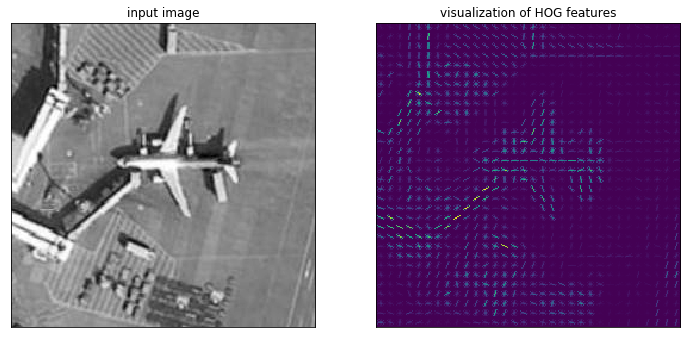

In [5]:
#load in image
with fs.open('cdi-workshop/imrecog_data/NWPU-RESISC45/test/airplane/airplane_700.jpg', 'rb') as f:
    image = color.rgb2gray(imread(f, 'jpg'))

##extract HOG features
_, hog_vis = feature.hog(image, visualise=True)

##create a figure and show the input image and HOG features side by side 
fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

Playing with algorithm inputs ...

C:\Users\ddb265\AppData\Local\Continuum\anaconda3\envs\tfpy35_workshop\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\ddb265\AppData\Local\Continuum\anaconda3\envs\tfpy35_workshop\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


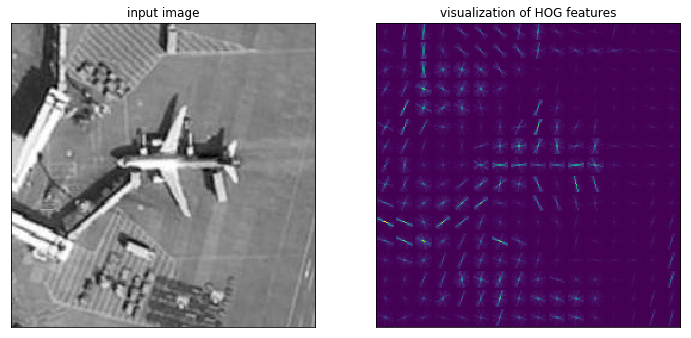

In [6]:
##extract HOG features
_, hog_vis = feature.hog(image, orientations=30, visualise=True, transform_sqrt=True, pixels_per_cell=(16, 16))

##create a figure and show the input image and HOG features side by side 
fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

### Principal Components

PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more. 

This time we're treating each pixel as a unique feature, and we'll use PCA to reduce the number of features

First, let's set up a dataset to use. The EuroSAT data has images in 10 categories

In [7]:
## list the subdirectories of the EuroSAT data
cats = [f for f in fs.ls('cdi-workshop/imrecog_data/EuroSAT')]
cats

['cdi-workshop/imrecog_data/EuroSAT/AnnualCrop',
 'cdi-workshop/imrecog_data/EuroSAT/Forest',
 'cdi-workshop/imrecog_data/EuroSAT/HerbaceousVegetation',
 'cdi-workshop/imrecog_data/EuroSAT/Highway',
 'cdi-workshop/imrecog_data/EuroSAT/Industrial',
 'cdi-workshop/imrecog_data/EuroSAT/Pasture',
 'cdi-workshop/imrecog_data/EuroSAT/PermanentCrop',
 'cdi-workshop/imrecog_data/EuroSAT/Residential',
 'cdi-workshop/imrecog_data/EuroSAT/River',
 'cdi-workshop/imrecog_data/EuroSAT/SeaLake']

We'll import a function that will resize all images to a specified size

In [8]:
from skimage.transform import resize

In [9]:
## read in all the Highway files, convert to greyscale, resize, and flatten to a 1D vector
images = []
files = [f for f in fs.ls('cdi-workshop/imrecog_data/EuroSAT/Highway') if f.endswith('.jpg')]
for file in files:
    with fs.open(file, 'rb') as f:
        images.append(resize(color.rgb2gray(imread(f, 'jpg')), (128, 128)).flatten())

C:\Users\ddb265\AppData\Local\Continuum\anaconda3\envs\tfpy35_workshop\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\ddb265\AppData\Local\Continuum\anaconda3\envs\tfpy35_workshop\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [10]:
## transform image data from list to numpy array
images = np.asarray(images)

In [11]:
np.shape(images)

(2500, 16384)

In principal component analysis, the relationship between data dimensions is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset

In [12]:
from sklearn.decomposition import PCA
PCA?

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

### PCA demonstration

Here is an example of using PCA as a dimensionality reduction transform:

In [13]:
# make PCA object with 1 component
pca  =  PCA(n_components =1)
## fit to data
pca.fit(images)
## apply the transformation
images_pca = pca.transform(images)
## compare shapes
print("original shape:   ", images.shape)
print("transformed shape:", images_pca.shape)

original shape:    (2500, 16384)
transformed shape: (2500, 1)


The transformed data has been reduced to a single dimension. To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

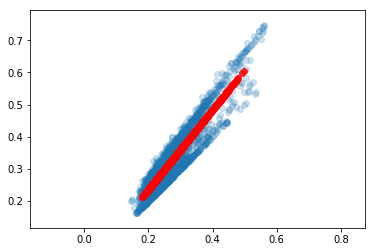

In [14]:
images_new = pca.inverse_transform(images_pca)
plt.scatter(images[:, 0], images[:, 1], alpha=0.2)
plt.scatter(images_new[:, 0], images_new[:, 1], color='r', alpha=0.8)
plt.axis('equal');

The blue points are the original data, while the red points are the projected version. 

This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance. The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

### Dimensionality reduction of airplane images

We're going to find 100 principal components using 
* Randomized SVD (singular value decomposition) solver
* Whiten (vectors are multiplied by the $\sqrt(N)$ and then divided by the singular values to ensure uncorrelated outputs)

In [15]:
pca = PCA(svd_solver='randomized', n_components=100, whiten=True, random_state=42)
pca.fit(images)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=True)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [16]:
print(pca.components_)

[[ 3.89361117e-03  4.83971817e-03  4.81115085e-03 ...  5.67183028e-03
   5.70519788e-03  4.24365046e-03]
 [ 7.46320670e-05  4.06571564e-04  4.71975555e-04 ... -1.39706296e-03
  -1.25208050e-03 -4.18660884e-04]
 [ 1.74481436e-03  4.30603571e-03  4.32354988e-03 ... -6.76379062e-03
  -6.58135980e-03 -2.98744982e-03]
 ...
 [ 3.82300268e-04  3.25865142e-03  4.32760668e-03 ... -5.66535806e-03
  -5.86230626e-03 -4.42381471e-03]
 [-8.08589050e-03 -1.55715643e-02 -1.50817860e-02 ...  4.58927150e-03
   6.53531948e-03  3.95593908e-03]
 [-4.18776596e-03 -5.49131357e-03 -3.20079285e-03 ... -7.45865808e-03
  -7.94246204e-03 -3.28422417e-03]]


In [17]:
print(pca.explained_variance_)

[189.1714445   12.81649284  10.54824204   6.73181925   4.98579525
   4.29362825   3.88256814   3.45557695   2.92287123   2.31485041
   2.18644421   2.14457158   2.10598808   1.9242585    1.7772866
   1.58397594   1.51738772   1.40110059   1.35079817   1.30883564
   1.28142337   1.15758859   1.1120262    1.09314751   0.9789888
   0.9237067    0.90422675   0.89258243   0.85455653   0.83053573
   0.80269801   0.77815157   0.75099244   0.70426542   0.67709741
   0.65286464   0.63836623   0.63148807   0.60715993   0.60445887
   0.59005126   0.5794699    0.56997341   0.55014582   0.5370339
   0.52779951   0.50422714   0.48650708   0.48072986   0.46987934
   0.45884022   0.44462778   0.44217761   0.43229052   0.43166278
   0.42291696   0.41907613   0.39974361   0.39645434   0.37804623
   0.3747919    0.37447884   0.36209496   0.36072147   0.35494091
   0.34579132   0.34335722   0.33079743   0.3274531    0.3217324
   0.31705895   0.31680037   0.30896426   0.29868594   0.29570334
   0.29259935 

It can be interesting to visualize the images associated with the first several principal components (these components are known as "eigenvectors")

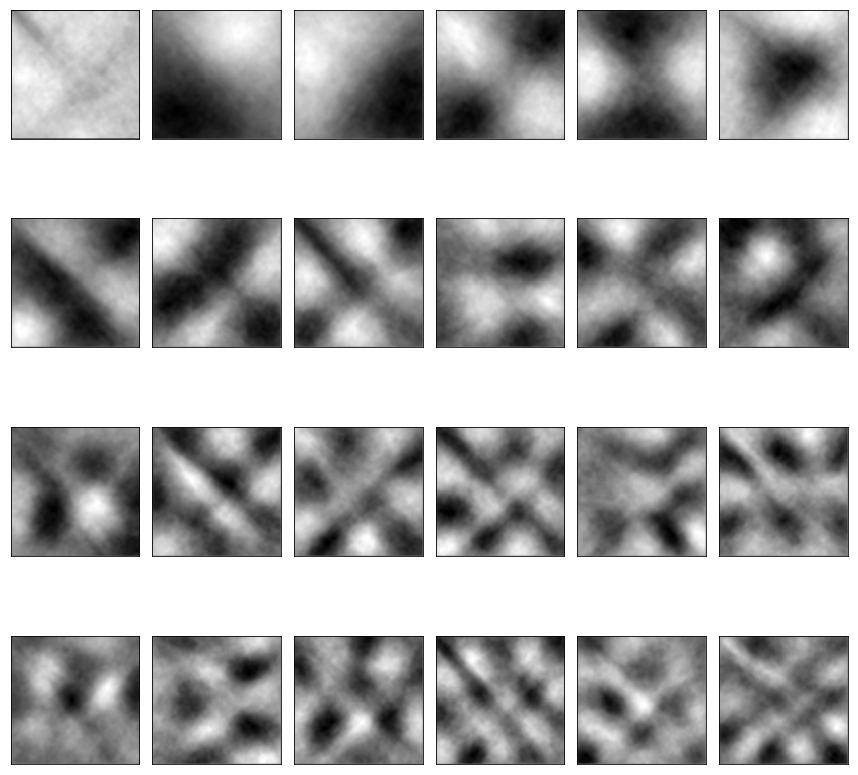

In [18]:
fig, axes = plt.subplots(4, 6, figsize=(15, 15),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(128, 128), cmap='gray')

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

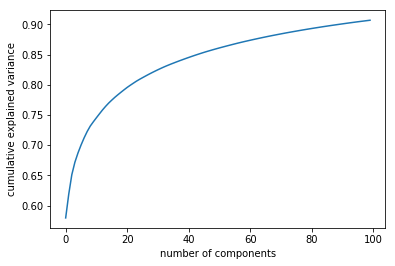

In [19]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We see that these 50 components account for ~85% of the variance. That would lead us to believe that using these 50 components, we would recover most of the essential characteristics of the data. To make this more concrete, we can compare the input images with the images reconstructed from these 50 components:

In [20]:
# Compute the components and projected images
components = pca.transform(images)
projected = pca.inverse_transform(components)

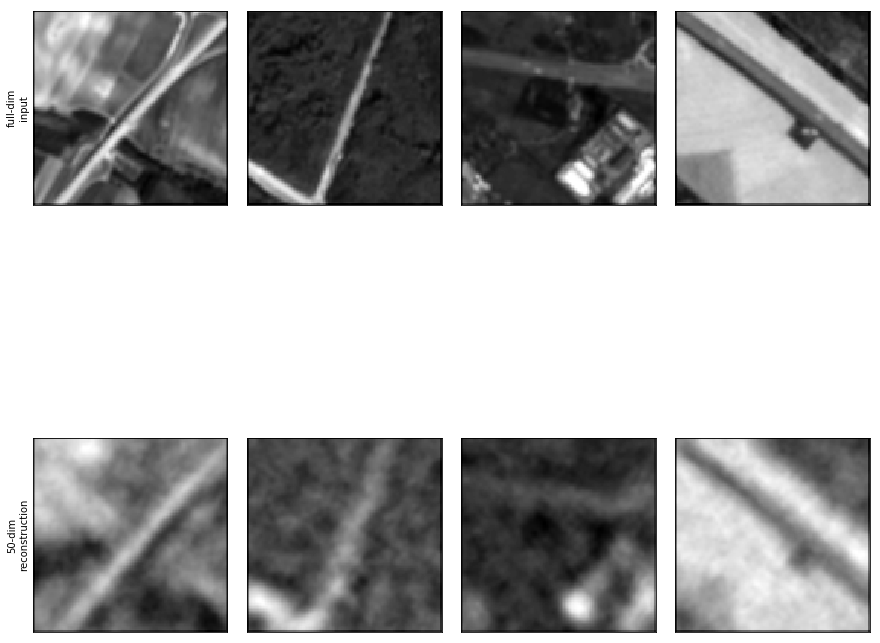

In [21]:
# Plot the results
fig, ax = plt.subplots(2, 4, figsize=(15, 15),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(4):
    ax[0, i].imshow(images[i].reshape(128, 128), cmap='gray')
    ax[1, i].imshow(projected[i].reshape(128, 128), cmap='gray')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('50-dim\nreconstruction');

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 50 of the initial features.

Although it reduces the dimensionality of the data, the projected images contain enough information that we might, by eye, recognize the individuals in the image. What this means is that our classification algorithm needs to be trained on 50-dimensional data rather than very high dimensional data, which depending on the particular algorithm we choose, can lead to a much more efficient classification.

## Exercises

1. How many principal components do you need for stationary camera time-series?

We have several time-series of images from a stationary camera in Grand Canyon. Such as this one:

In [ ]:
files = [f for f in fs.ls('cdi-workshop/semseg_data/RC1671L/flood4')]

In [ ]:
from scipy.misc import imresize

with fs.open(files[0], 'rb') as f:
    nx, ny = np.shape(imresize(color.rgb2gray(imread(f, 'jpg')), .25))

images = []
for file in files:
    with fs.open(file, 'rb') as f:
        images.append(imresize(color.rgb2gray(imread(f, 'jpg')), .25).flatten())

Make a plot showing all eight images

Decompose the image into principal components. How many components are needed to explain >85% of the variance?

Make a plot to visualize those components. What do you notice?

Transform the images into principal components, then do the inverse transform to get projected images

Make a plot comparing the original with projected images